In [12]:
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import losses
from keras import regularizers
from keras import backend as K
import tensorflow as tf

In [2]:
import os
import shutil
import pandas as pd

# Define the source directories and the target directory
train_dir = 'cars_train\cars_train'
test_dir = 'cars_test\cars_test'
merged_dir = 'car_dataset'

# Create the target directory if it doesn't exist
os.makedirs(merged_dir, exist_ok=True)

# Function to copy files from source to target directory
def copy_files(source_dir, target_dir):
    for file_name in os.listdir(source_dir):
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(target_dir, file_name))

# Copy files from train and test directories to the merged directory
copy_files(train_dir, merged_dir)
copy_files(test_dir, merged_dir)


<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Admin\AppData\Local\Temp\ipykernel_21244\881994199.py:6: SyntaxWarning: invalid escape sequence '\c'
  train_dir = 'cars_train\cars_train'
C:\Users\Admin\AppData\Local\Temp\ipykernel_21244\881994199.py:7: SyntaxWarning: invalid escape sequence '\c'
  test_dir = 'cars_test\cars_test'


In [3]:
# Define the CSV files
train_csv = 'cardatasettrain.csv'
test_csv = 'cardatasettest.csv'
merged_csv = 'car_dataset.csv'

# Read the CSV files
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# Merge the dataframes
merged_df = pd.concat([train_df, test_df], ignore_index=True)

# Save the merged dataframe to a new CSV file
merged_df.to_csv(merged_csv, index=False)

Total entries in CSV: 16185
Total image files in folder: 8144
Entries with existing image files: 16185
Entries with missing image files: 0
   Unnamed: 0   x1   y1    x2    y2  Class      image  file_exists
0           0   39  116   569   375   14.0  00001.jpg         True
1           1   36  116   868   587    3.0  00002.jpg         True
2           2   85  109   601   381   91.0  00003.jpg         True
3           3  621  393  1484  1096  134.0  00004.jpg         True
4           4   14   36   133    99  106.0  00005.jpg         True


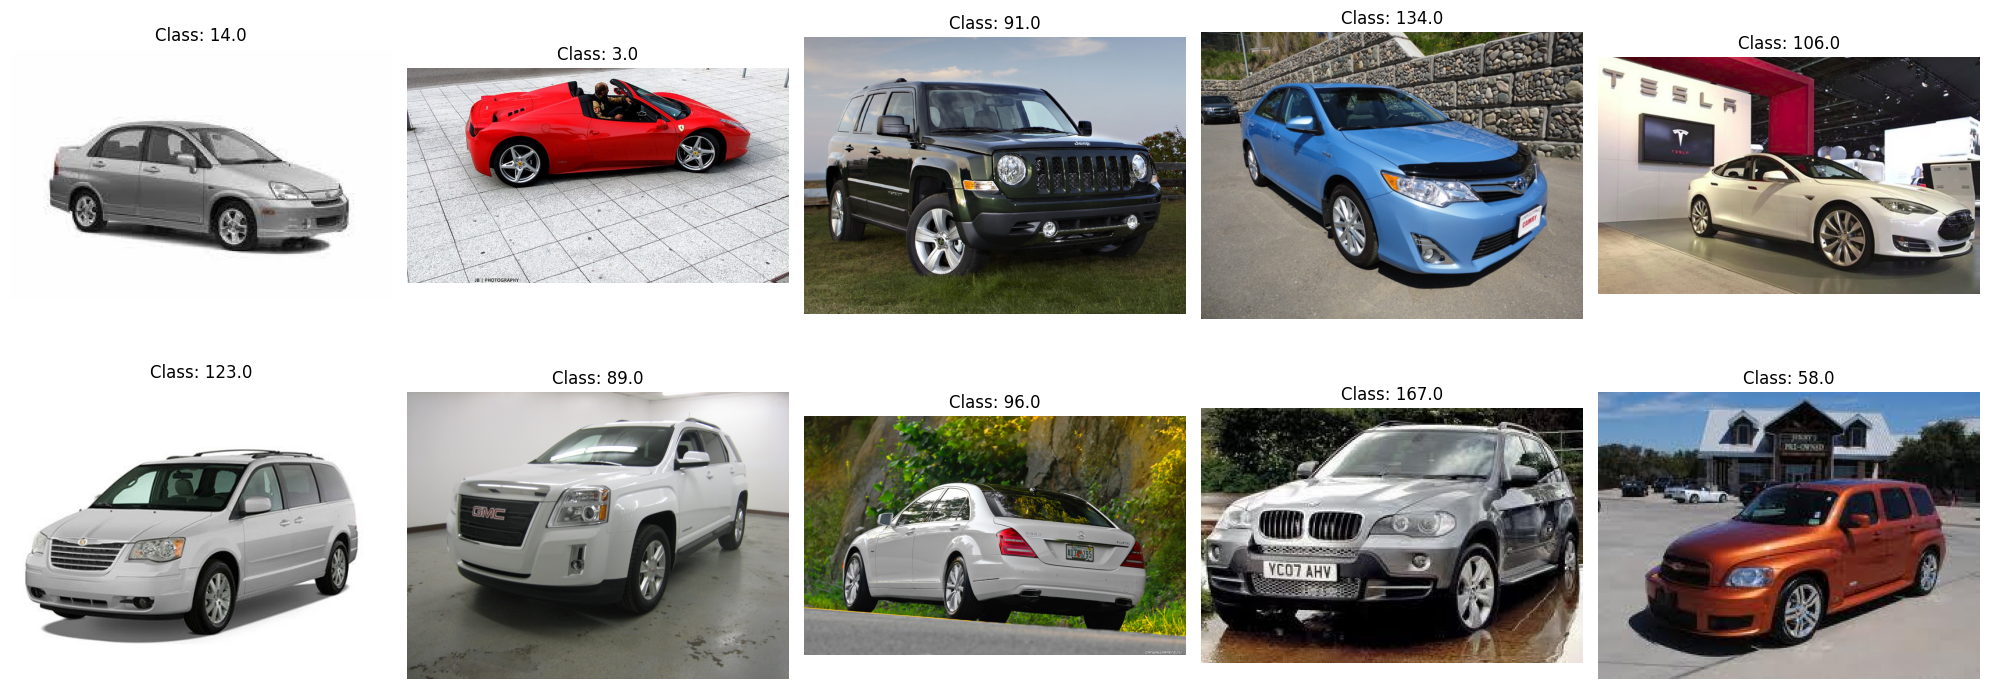

In [9]:
#create dataframe from folder car_dataset and car_dataset.csv
import os

#create dataframe from folder car_dataset and car_dataset.csv
# Read the merged CSV file
df = pd.read_csv('car_dataset.csv')

# Get the list of image files in the car_dataset folder
image_files = os.listdir('car_dataset')

# Create a new column 'file_exists' to check if the image file exists
df['file_exists'] = df['image'].isin(image_files)

# Print some information about the dataset
print(f"Total entries in CSV: {len(df)}")
print(f"Total image files in folder: {len(image_files)}")
print(f"Entries with existing image files: {df['file_exists'].sum()}")
print(f"Entries with missing image files: {(~df['file_exists']).sum()}")

# Optionally, you can remove entries with missing image files
# df = df[df['file_exists']]
# df = df.drop('file_exists', axis=1)

# Display the first few rows of the dataframe
print(df.head())
# Display the picture of the car and the car's name
import matplotlib.pyplot as plt

# Assuming 'image' column contains the file names and 'name' column contains the car names
# Display the first 10 image
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(10):
    img = plt.imread(f'car_dataset/{df.iloc[i]["image"]}')
    axes[i].imshow(img)
    axes[i].set_title(f"Class: {df.iloc[i]['Class']}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()



In [10]:
#split the dataframe into 2 dataframe, one for training and one for testing
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)


In [11]:
print(f"Total entries in CSV: {len(df)}")
print(f"Total entries in train_df: {len(train_df)}")
print(f"Total entries in test_df: {len(test_df)}")


Total entries in CSV: 16185
Total entries in train_df: 12948
Total entries in test_df: 3237


In [13]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import numpy as np

# See https://keras.io/api/applications/ for details

class FeatureExtractor:
    def __init__(self):
        base_model = VGG16(weights='imagenet')
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

    def extract(self, img):
        """
        Extract a deep feature from an input image
        Args:
            img: from PIL.Image.open(path) or tensorflow.keras.preprocessing.image.load_img(path)

        Returns:
            feature (np.ndarray): deep feature with the shape=(4096, )
        """
        img = img.resize((224, 224))  # VGG must take a 224x224 img as an input
        img = img.convert('RGB')  # Make sure img is color
        x = image.img_to_array(img)  # To np.array. Height x Width x Channel. dtype=float32
        x = np.expand_dims(x, axis=0)  # (H, W, C)->(1, H, W, C), where the first elem is the number of img
        x = preprocess_input(x)  # Subtracting avg values for each pixel
        feature = self.model.predict(x)[0]  # (1, 4096) -> (4096, )
        return feature / np.linalg.norm(feature)  # Normalize


In [15]:
model = FeatureExtractor()

# Extract features for training images
train_features = {}
for img_path in train_df['image']:
    img = image.load_img(f'car_dataset/{img_path}', target_size=(224, 224))
    feature = model.extract(img)
    train_features[img_path] = feature

KeyboardInterrupt: 